In [1]:
import numpy as np
import h5py
import glob
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Deep learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
from scipy.stats import pearsonr, spearmanr
import os
import matplotlib.cm as cm

2025-04-08 20:49:05.991036: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 20:49:07.265288: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 20:49:07.527362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744170547.772761 3049638 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744170548.018588 3049638 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744170549.729726 3049638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Function to calculate reconstruction MSE
def calculate_mse(model, electron_features, photon_features, vertices):
    vertices = vertices.reshape(vertices.shape[0], 1, vertices.shape[1])
    # Prepare inputs
    inputs = {
        'electron_input': electron_features,
        'photon_input': photon_features,
        'vertex_input': vertices
    }
    
    # Get model predictions
    predictions = model.predict(inputs, batch_size=2048)
    
    # Calculate MSE for electrons
    electron_mse = np.mean(
        np.square(predictions['electron_output'] - electron_features),
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Calculate MSE for photons
    photon_mse = np.mean(
        np.square(predictions['photon_output'] - photon_features),
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Total MSE (average of electron and photon MSEs)
    total_mse = (electron_mse + photon_mse) / 2
    
    return total_mse

In [3]:
# Load data
max_events = 100000
print("Loading test data...")
test_electron_features = np.load('test_data_e.npy')[:max_events]
test_photon_features = np.load('test_data_p.npy')[:max_events]
test_vertices = np.load('test_data_v.npy')[:max_events]

print("Loading signal data...")
signal_electron_features = np.load('output_model_directory/signal_data_e_models.npy')
signal_photon_features = np.load('output_model_directory/signal_data_p_models.npy')
signal_vertices = np.load('output_model_directory/signal_data_v_models.npy')
signal_models = np.load('output_model_directory/signal_models.npy')
signal_job_ids = np.load('output_model_directory/signal_job_ids.npy')

print(f"Test data shapes: electrons {test_electron_features.shape}, photons {test_photon_features.shape}, vertices {test_vertices.shape}")
print(f"Signal data shapes: electrons {signal_electron_features.shape}, photons {signal_photon_features.shape}, vertices {signal_vertices.shape}")
print(f"Signal models shape: {signal_models.shape}")
print(f"Unique signal models: {np.unique(signal_models)}")

Loading test data...
Loading signal data...
Test data shapes: electrons (100000, 4, 15), photons (100000, 4, 13), vertices (100000, 3)
Signal data shapes: electrons (2080280, 4, 15), photons (2080280, 4, 13), vertices (2080280, 3)
Signal models shape: (2080280,)
Unique signal models: ['110_30_0p1ns' '110_30_0p5ns' '110_30_10ns' '110_30_2ns' '200_10_0p1ns'
 '200_10_10ns' '200_10_2ns' '200_15_0p5ns' '200_15_10ns' '200_15_2ns'
 '200_50_10ns' '200_50_2ns' '200_90_0p1ns' '200_90_0p5ns' '200_90_10ns'
 '200_90_2ns' '400_100_0p1ns' '400_100_0p5ns' '400_100_10ns' '400_100_2ns'
 '400_10_0p1ns' '400_10_0p5ns' '400_10_10ns' '400_15_0p1ns' '400_15_0p5ns'
 '400_15_10ns' '400_190_0p1ns' '400_190_0p5ns' '400_190_10ns'
 '600_10_0p1ns' '600_10_10ns' '600_10_2ns' '600_150_0p1ns' '600_150_0p5ns'
 '600_150_10ns' '600_150_2ns' '600_15_0p1ns' '600_15_0p5ns' '600_15_10ns'
 '600_15_2ns' '600_290_0p1ns' '600_290_0p5ns' '600_290_10ns' '600_290_2ns'
 '60_25_0p5ns' '60_25_10ns' '60_25_2ns']


In [4]:
print(test_electron_features.shape)

(100000, 4, 15)


In [5]:
def create_embedding_network(input_dim, hidden_dim, output_dim):
    """Create a deep embedding network."""
    return keras.Sequential([
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(output_dim)
    ])

class TransformerEncoderBlock(layers.Layer):
    """Transformer encoder block with multi-head attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def call(self, inputs):
        attention_output = self.attention(query=inputs, key=inputs, value=inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecoderBlock(layers.Layer):
    """Transformer decoder block with multi-head self and cross attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.self_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.cross_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)
        
    def call(self, inputs, encoder_outputs):
        # Self attention
        self_attention_output = self.self_attention(
            query=inputs,
            key=inputs,
            value=inputs
        )
        self_attention_output = self.dropout1(self_attention_output)
        out1 = self.layernorm1(inputs + self_attention_output)
        
        # Cross attention with encoder outputs
        cross_attention_output = self.cross_attention(
            query=out1,
            key=encoder_outputs,
            value=encoder_outputs
        )
        cross_attention_output = self.dropout2(cross_attention_output)
        out2 = self.layernorm2(out1 + cross_attention_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.layernorm3(out2 + ffn_output)

In [6]:
electron_features_list = [
    'electron_E', 'electron_pt', 'electron_eta', 'electron_phi',
    'electron_time',
    'electron_d0', 'electron_z0', 'electron_dpt',
    'electron_nPIX', 'electron_nMissingLayers',
    'electron_chi2', 'electron_numberDoF',  # Will need to handle ratio
    'electron_f1', 'electron_f3', 'electron_z'
]

photon_features_list = [
    'photon_E', 'photon_pt', 'photon_eta', 'photon_phi',
    'photon_time',
    'photon_maxEcell_E',
    'photon_f1', 'photon_f3', 'photon_r1', 'photon_r2',
    'photon_etas1', 'photon_phis1', 'photon_z'
]

In [7]:
class ParticleTransformer(keras.Model):
    """Complete transformer model for particle physics data."""
    def __init__(
        self,
        max_electrons=4,
        max_photons=4,
        electron_embedding_dim=15,
        photon_embedding_dim=13,
        vertex_embedding_dim=3,
        common_embedding_dim=31,
        num_encoder_layers=4,
        num_decoder_layers=4,
        num_heads=4
    ):
        super().__init__()
        
        # Input embeddings with different dimensions
        self.electron_embedding = create_embedding_network(
            len(electron_features_list),  # electron feature dim
            electron_embedding_dim,
            common_embedding_dim
        )
        self.photon_embedding = create_embedding_network(
            len(photon_features_list),  # photon feature dim
            photon_embedding_dim,
            common_embedding_dim
        )
        self.vertex_embedding = create_embedding_network(
            3,   # vertex feature dim
            vertex_embedding_dim,
            common_embedding_dim
        )
              
        # Transformer encoder layers
        self.encoder_layers = [
            TransformerEncoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_encoder_layers)
        ]
        
        # Transformer decoder layers
        self.decoder_layers = [
            TransformerDecoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_decoder_layers)
        ]
        
        # Output projection layers
        self.electron_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(electron_features_list))  # electron features
        ])
        self.photon_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(photon_features_list))  # photon features
        ])
        
    def encode_particles(self, electron_inputs, photon_inputs, vertex_inputs):
        # Embed particles
        e_embedded = self.electron_embedding(electron_inputs)
        p_embedded = self.photon_embedding(photon_inputs)
        v_embedded = self.vertex_embedding(vertex_inputs)
        
        # Combine embeddings
        combined = tf.concat([e_embedded, p_embedded, v_embedded], axis=1)
        
        # Pass through encoder layers
        encoded = combined
        intermediates = []
        for encoder_layer in self.encoder_layers:
            encoded = encoder_layer(encoded)
            intermediates.append(encoded)
            
        return encoded, intermediates
        
    def decode_particles(self, encoded, encoder_intermediates):
        decoded = encoded
        
        # Pass through decoder layers with corresponding encoder outputs
        for decoder_layer, encoder_output in zip(self.decoder_layers, encoder_intermediates):
            decoded = decoder_layer(decoded, encoder_output)
            
        return decoded
        
    def call(self, inputs):
        # Unpack inputs
        electron_inputs = inputs['electron_input']
        photon_inputs = inputs['photon_input']
        vertex_inputs = inputs['vertex_input']
        
        # Encode
        encoded, encoder_intermediates = self.encode_particles(
            electron_inputs, photon_inputs, vertex_inputs)
        
        # Decode
        decoded = self.decode_particles(encoded, encoder_intermediates)
        
        # Split and reconstruct
        e_len = electron_inputs.shape[1]
        electron_decoded = decoded[:, :e_len]
        photon_decoded = decoded[:, e_len:-1]
        
        # Output
        return {
            'electron_output': self.electron_reconstruction(electron_decoded),
            'photon_output': self.photon_reconstruction(photon_decoded)
        }

In [8]:
class ParticleDataGenerator(keras.utils.Sequence):
    """Data generator for particle physics events."""
    def __init__(self, data, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.electron_data, self.photon_data, self.vertex_data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.vertex_data))
        self.on_epoch_end()
        
    def __len__(self):
        """Number of batches per epoch."""
        return len(self.indices) // self.batch_size
        
    def on_epoch_end(self):
        """Called at the end of every epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):
        """Get one batch of data."""
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Prepare batch data
        x = {
            'electron_input': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_input': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32),
            'vertex_input': tf.convert_to_tensor(self.vertex_data[batch_indices, np.newaxis, :], dtype=tf.float32)
        }
        
        y = {
            'electron_output': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_output': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32)
        }
        
        return x, y


In [9]:
# Create the model with the correct dimensions
model = ParticleTransformer(
    max_electrons=4,
    max_photons=4,
    electron_embedding_dim=15,
    photon_embedding_dim=13,
    vertex_embedding_dim=3,
    common_embedding_dim=8,
    num_encoder_layers=4,
    num_decoder_layers=4,
    num_heads=4
)


# Create model with specified input shapes
electron_input = keras.Input(shape=(4, len(electron_features_list)), name='electron_input')
photon_input = keras.Input(shape=(4, len(photon_features_list)), name='photon_input')
vertex_input = keras.Input(shape=(1, 3), name='vertex_input')

outputs = model({
    'electron_input': electron_input,
    'photon_input': photon_input,
    'vertex_input': vertex_input
})

model = keras.Model(
    inputs={
        'electron_input': electron_input,
        'photon_input': photon_input,
        'vertex_input': vertex_input
    },
    outputs=outputs
)

# Load weights
model_path = 'particle_transformer_v1.keras'
# model_path = 'model_v1.weights.h5'
print(f"Loading weights from {model_path}...")
# Try first with load_weights
model.load_weights(model_path)
print("Weights loaded successfully.")

2025-04-08 20:52:46.616918: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Loading weights from particle_transformer_v1.keras...
Weights loaded successfully.


In [10]:
print(signal_electron_features[0])

[[-6.36558436e-01 -6.36682108e-01 -1.46194748e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.91689508e-01 -2.97815966e-01 -6.36035711e-01 -6.36941296e-01
  -5.94128432e-01 -4.22699628e-01  2.57189577e-04]
 [-6.36558436e-01 -6.36682108e-01 -1.46194748e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.91689508e-01 -2.97815966e-01 -6.36035711e-01 -6.36941296e-01
  -5.94128432e-01 -4.22699628e-01  2.57189577e-04]
 [-6.36558436e-01 -6.36682108e-01 -1.46194748e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.91689508e-01 -2.97815966e-01 -6.36035711e-01 -6.36941296e-01
  -5.94128432e-01 -4.22699628e-01  2.57189577e-04]
 [-6.36558436e-01 -6.36682108e-01 -1.46194748e-03 -3.79454986e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.91689508e-01 -2.97815966e-01 -6.36035711e-01 -6.36941296e-01
  -5.94128432e-01 -4.22699628e-01  2.57189577e-04]]


In [11]:
# Calculate anomaly scores
print("Calculating test data anomaly scores...")
test_scores = calculate_mse(model, test_electron_features, test_photon_features, test_vertices)

print("Calculating signal data anomaly scores...")
signal_scores = calculate_mse(model, signal_electron_features, signal_photon_features, signal_vertices)

# Create labels (0 for test/background, 1 for signal)
test_labels = np.zeros(len(test_scores))
signal_labels = np.ones(len(signal_scores))

# Combine scores and labels
all_scores = np.concatenate([test_scores, signal_scores])
all_labels = np.concatenate([test_labels, signal_labels])

# Calculate overall ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

print(f"Overall ROC AUC: {roc_auc:.6f}")

Calculating test data anomaly scores...
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step
Calculating signal data anomaly scores...
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 117s 115ms/step
Overall ROC AUC: 0.900611


In [12]:
# Create a dictionary to store per-model results
model_results = {}

# Get list of unique models
unique_models = np.unique(signal_models)
print(f"Analyzing {len(unique_models)} unique signal models...")

# Perform analysis for each model separately
for model_name in unique_models:
    # Get mask for this model
    model_mask = signal_models == model_name
    
    # Get scores for this model only
    model_scores = signal_scores[model_mask]
    
    # Create model-specific labels
    model_labels = np.ones(len(model_scores))
    
    # Combine with test data for ROC calculation
    model_all_scores = np.concatenate([test_scores, model_scores])
    model_all_labels = np.concatenate([test_labels, model_labels])
    
    # Calculate model-specific ROC
    model_fpr, model_tpr, model_thresholds = roc_curve(model_all_labels, model_all_scores)
    model_roc_auc = auc(model_fpr, model_tpr)
    
    # Parse parameters from model name
    parts = model_name.split('_')
    mass1 = int(parts[0])
    mass2 = int(parts[1])
    
    # Handle lifetime format (convert 0p1ns to 0.1)
    lifetime_str = parts[2].replace('ns', '')
    lifetime = float(lifetime_str.replace('p', '.'))
    
    # Calculate statistics for this model
    model_results[model_name] = {
        'num_events': np.sum(model_mask),
        'mean_score': np.mean(model_scores),
        'scores': model_scores,
        'roc_auc': model_roc_auc,
        'mass1': mass1,
        'mass2': mass2,
        'lifetime': lifetime
    }
    
    print(f"Model {model_name}: {np.sum(model_mask)} events, ROC AUC = {model_roc_auc:.6f}")


Analyzing 47 unique signal models...
Model 110_30_0p1ns: 83352 events, ROC AUC = 0.934074
Model 110_30_0p5ns: 77710 events, ROC AUC = 0.912968
Model 110_30_10ns: 16744 events, ROC AUC = 0.741150
Model 110_30_2ns: 26963 events, ROC AUC = 0.814510
Model 200_10_0p1ns: 79792 events, ROC AUC = 0.873177
Model 200_10_10ns: 3367 events, ROC AUC = 0.605530
Model 200_10_2ns: 15817 events, ROC AUC = 0.652927
Model 200_15_0p5ns: 64946 events, ROC AUC = 0.789971
Model 200_15_10ns: 6487 events, ROC AUC = 0.610521
Model 200_15_2ns: 13917 events, ROC AUC = 0.666470
Model 200_50_10ns: 23953 events, ROC AUC = 0.717098
Model 200_50_2ns: 68060 events, ROC AUC = 0.817452
Model 200_90_0p1ns: 93391 events, ROC AUC = 0.928106
Model 200_90_0p5ns: 88904 events, ROC AUC = 0.951236
Model 200_90_10ns: 17922 events, ROC AUC = 0.831741
Model 200_90_2ns: 74156 events, ROC AUC = 0.903417
Model 400_100_0p1ns: 98098 events, ROC AUC = 0.961969
Model 400_100_0p5ns: 48167 events, ROC AUC = 0.959555
Model 400_100_10ns: 2718

In [13]:
model_params = []
for model_name, results in model_results.items():
    model_params.append({
        'name': model_name,
        'mass1': results['mass1'],
        'mass2': results['mass2'],
        'lifetime': results['lifetime'],
        'roc_auc': results['roc_auc'],
        'mean_score': results['mean_score'],
        'num_events': results['num_events']
    })

# Convert to DataFrame for easier analysis
params_df = pd.DataFrame(model_params)

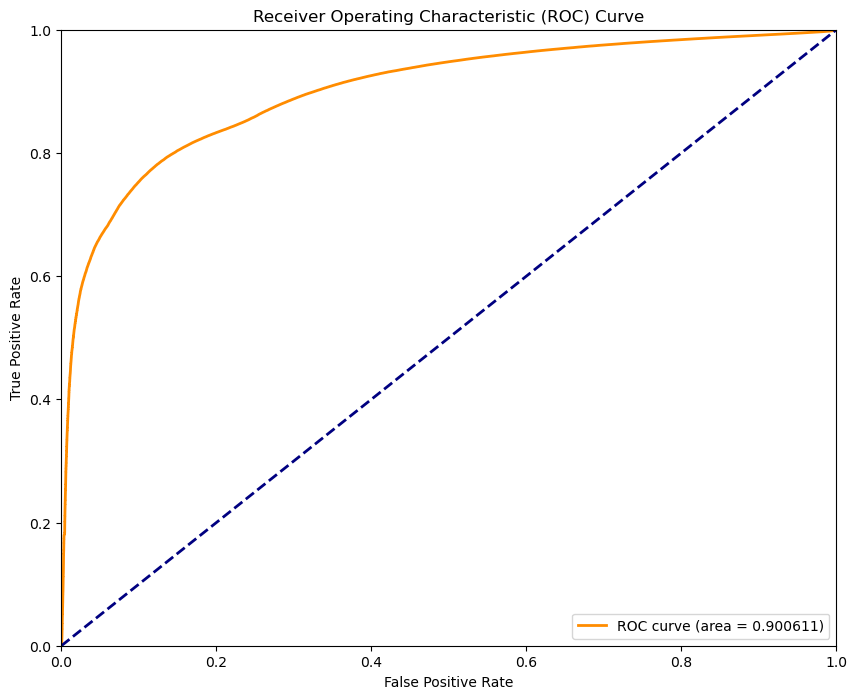

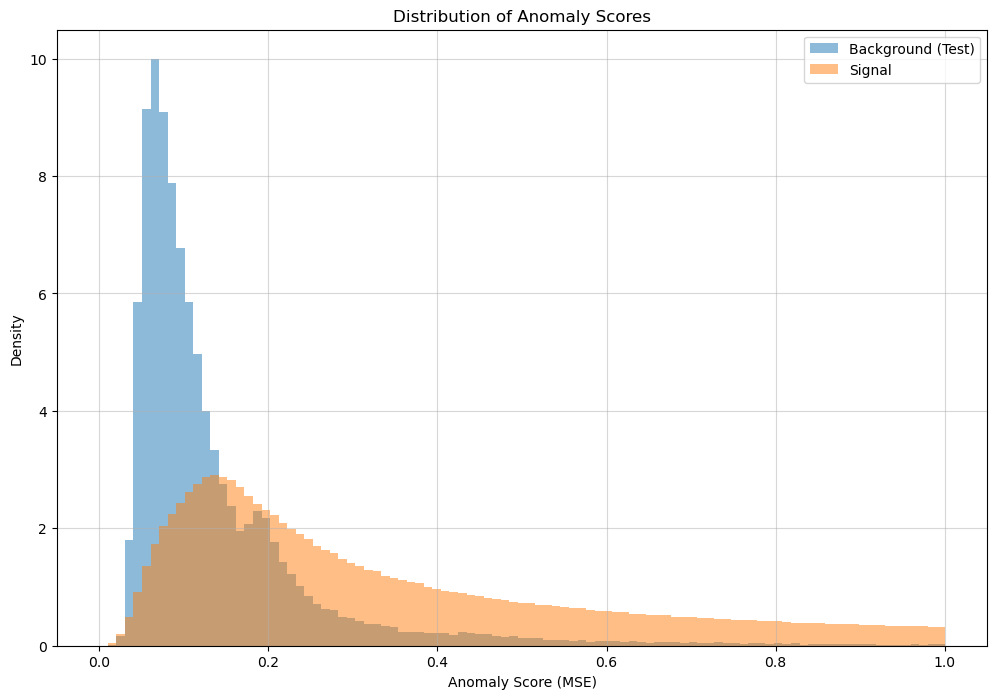

Test data: Mean MSE = 22.326866, Std = 6599.707268, Max = 2086590.704409
Signal data: Mean MSE = 1214.865365, Std = 1678587.860191
ROC AUC: 0.900611
Best threshold = 0.236098
At this threshold:
  True Positive Rate (TPR) = 0.792729
  False Positive Rate (FPR) = 0.135740
  Geometric Mean = 0.827722


In [22]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the figure
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot histograms of anomaly scores
plt.figure(figsize=(12, 8))
bins = np.linspace(0, 1, 100)

plt.hist(test_scores, bins=bins, alpha=0.5, label='Background (Test)', density=True)
plt.hist(signal_scores, bins=bins, alpha=0.5, label='Signal', density=True)
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Density')
# plt.yscale('log')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.grid(True, alpha=0.5)

# Save the histogram
plt.savefig('anomaly_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics
print(f"Test data: Mean MSE = {np.mean(test_scores):.6f}, Std = {np.std(test_scores):.6f}, Max = {np.max(test_scores):.6f}")
print(f"Signal data: Mean MSE = {np.mean(signal_scores):.6f}, Std = {np.std(signal_scores):.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

# Find the best threshold based on maximum geometric mean of TPR and (1-FPR)
gmeans = np.sqrt(tpr * (1-fpr))
best_idx = np.argmax(gmeans)
best_threshold = thresholds[best_idx]
best_gmean = gmeans[best_idx]

print(f"Best threshold = {best_threshold:.6f}")
print(f"At this threshold:")
print(f"  True Positive Rate (TPR) = {tpr[best_idx]:.6f}")
print(f"  False Positive Rate (FPR) = {fpr[best_idx]:.6f}")
print(f"  Geometric Mean = {best_gmean:.6f}")

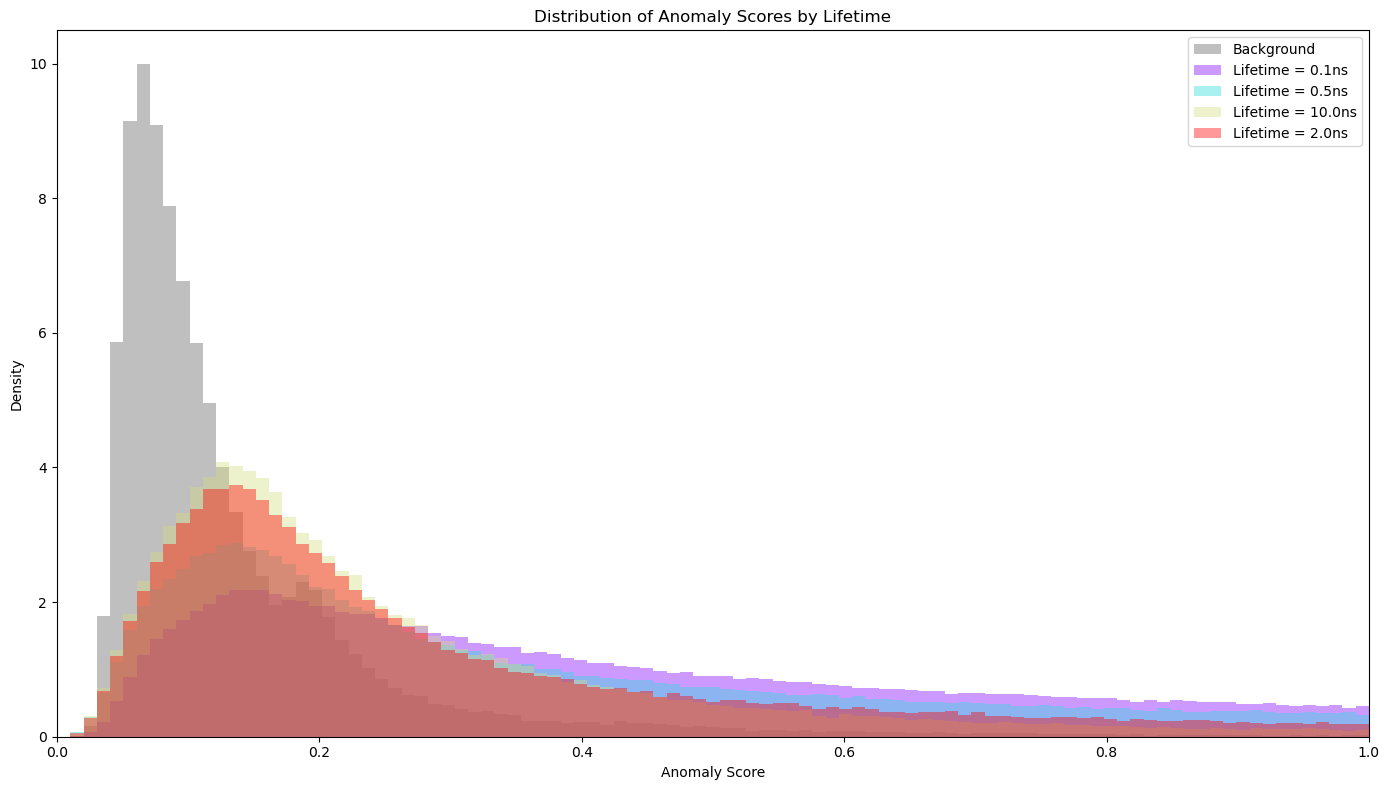

In [25]:
# Plot 1: Distribution of anomaly scores by lifetime
plt.figure(figsize=(14, 8))
bins = np.linspace(0, 1, 100)
# Plot background distribution first
plt.hist(test_scores, bins=bins, alpha=0.5, label='Background', density=True, color='gray')
plt.xlim([0, 1])
# Group models by lifetime
lifetime_groups = {}
for model_name, results in model_results.items():
    lifetime = results['lifetime']
    if lifetime not in lifetime_groups:
        lifetime_groups[lifetime] = []
    lifetime_groups[lifetime].extend(results['scores'])

# Use a colormap to distinguish different lifetimes
colors = cm.rainbow(np.linspace(0, 1, len(lifetime_groups)))

# Plot score distribution for each lifetime
for (lifetime, scores), color in zip(lifetime_groups.items(), colors):
    if len(scores) > 10:
        plt.hist(
            scores, 
            bins=bins, 
            alpha=0.4, 
            density=True,
            color=color,
            label=f'Lifetime = {lifetime}ns'
        )

plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.xlim([0, 1])
plt.title('Distribution of Anomaly Scores by Lifetime')
plt.legend()
plt.tight_layout()
plt.show()


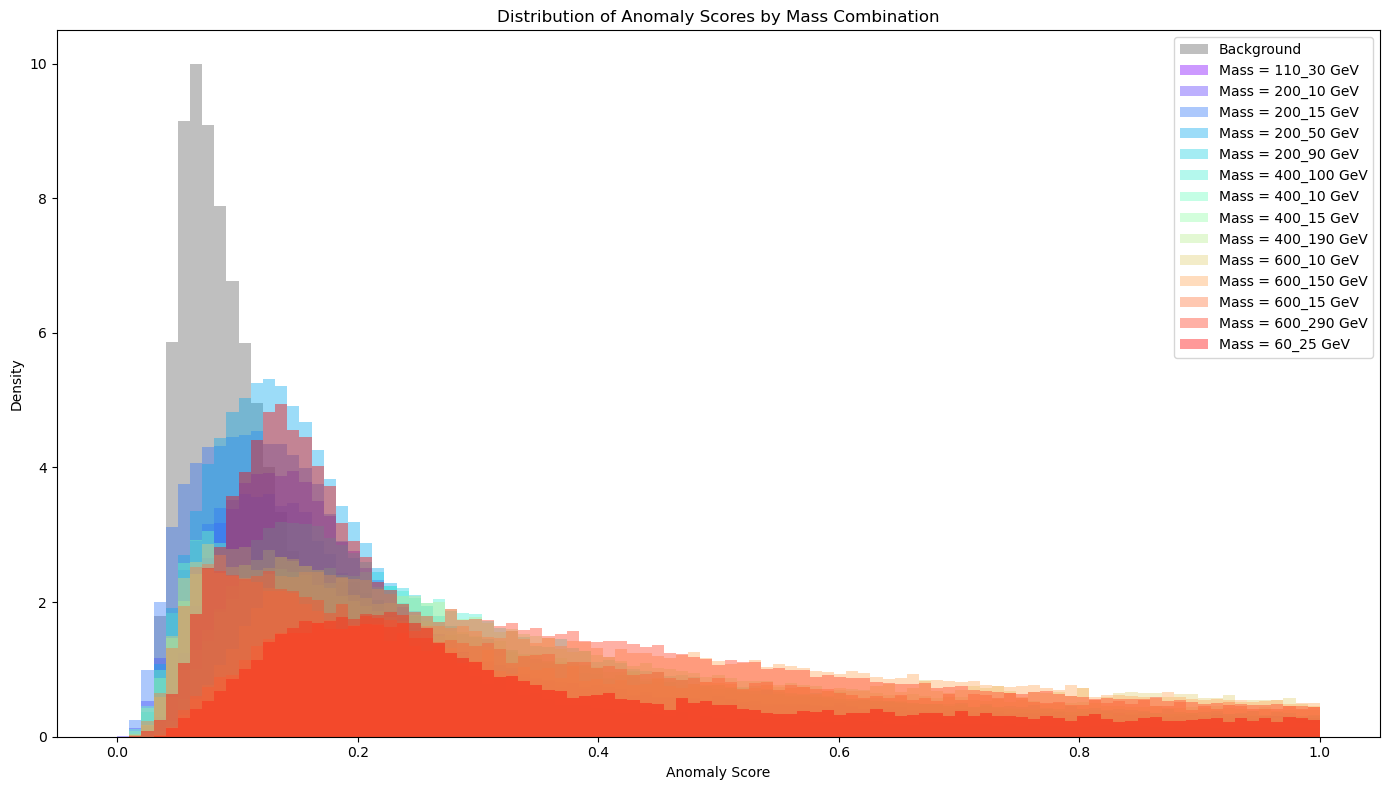

In [26]:
# Plot 2: Distribution of anomaly scores by mass combination
plt.figure(figsize=(14, 8))

# Plot background distribution first
plt.hist(test_scores, bins=bins, alpha=0.5, label='Background', density=True, color='gray')

# Group models by mass combination
mass_groups = {}
for model_name, results in model_results.items():
    mass_key = f"{results['mass1']}_{results['mass2']}"
    if mass_key not in mass_groups:
        mass_groups[mass_key] = []
    mass_groups[mass_key].extend(results['scores'])

# Use a colormap to distinguish different mass combinations
colors = cm.rainbow(np.linspace(0, 1, len(mass_groups)))

# Plot score distribution for each mass combination
for (mass_key, scores), color in zip(mass_groups.items(), colors):
    if len(scores) > 10:
        plt.hist(
            scores, 
            bins=bins, 
            alpha=0.4, 
            density=True,
            color=color,
            label=f'Mass = {mass_key} GeV'
        )

plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores by Mass Combination')
plt.legend()
plt.tight_layout()
plt.show()

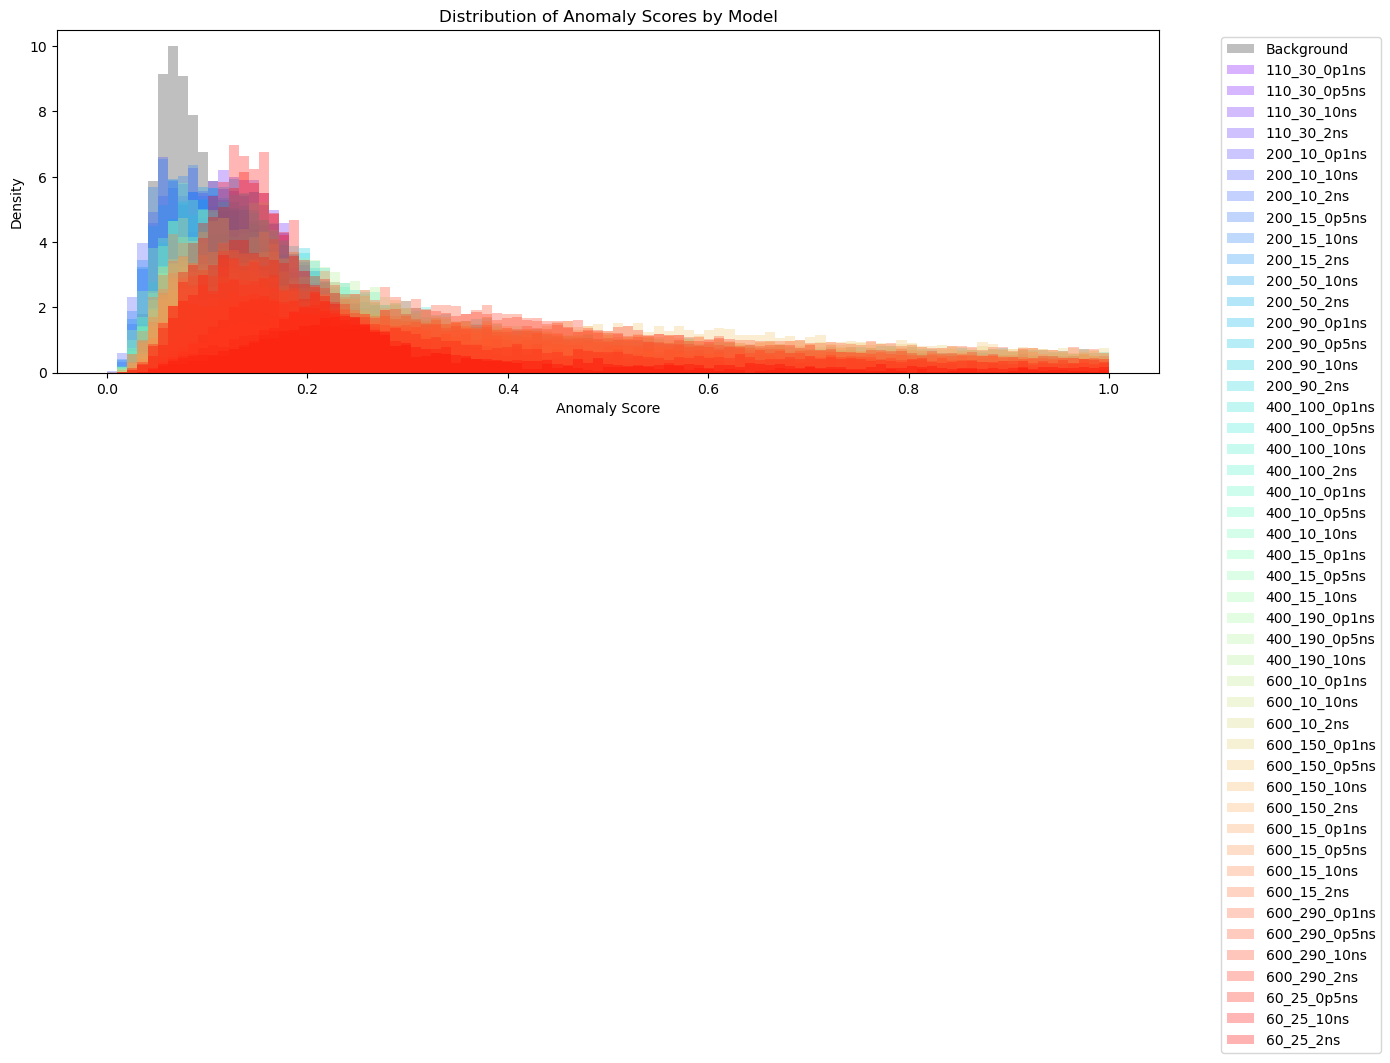

In [27]:
# Plot 3: Distribution of anomaly scores by model
plt.figure(figsize=(14, 8))

# Plot background distribution first
plt.hist(test_scores, bins=bins, alpha=0.5, label='Background', density=True, color='gray')

# Use a colormap to distinguish different models
colors = cm.rainbow(np.linspace(0, 1, len(model_results)))

# Plot score distribution for each model
for (model_name, results), color in zip(model_results.items(), colors):
    scores = results['scores']
    if len(scores) > 10:
        plt.hist(
            scores, 
            bins=bins, 
            alpha=0.3, 
            density=True,
            color=color,
            label=model_name
        )

plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores by Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
def calculate_feature_correlations(scores, e_feats, p_feats, method='pearson'):
    """
    Calculate correlations between anomaly scores and each feature.
    
    Parameters:
    -----------
    scores: numpy array of anomaly scores
    e_feats: electron features (shape: [n_events, n_electrons, n_features])
    p_feats: photon features (shape: [n_events, n_photons, n_features])
    method: correlation method ('pearson' or 'spearman')
    
    Returns:
    --------
    Dictionary with correlations for electron and photon features
    """
    results = {
        'electron': [],
        'photon': []
    }
    
    # Define correlation function based on method
    if method == 'pearson':
        corr_func = pearsonr
    else:  # spearman
        corr_func = spearmanr
    
    # Calculate for electron features
    for feat_idx in range(e_feats.shape[2]):
        # Average feature value across all electrons in each event
        feat_values = np.mean(e_feats[:, :, feat_idx], axis=1)
        # Only consider events where feature exists (non-zero)
        mask = ~np.isnan(feat_values) & (np.abs(feat_values) > 1e-10)
        
        if np.sum(mask) > 10:  # Need enough data points
            corr, p_value = corr_func(scores[mask], feat_values[mask])
            results['electron'].append({
                'feature_idx': feat_idx,
                'correlation': corr,
                'p_value': p_value
            })
    
    # Calculate for photon features
    for feat_idx in range(p_feats.shape[2]):
        # Average feature value across all photons in each event
        feat_values = np.mean(p_feats[:, :, feat_idx], axis=1)
        # Only consider events where feature exists (non-zero)
        mask = ~np.isnan(feat_values) & (np.abs(feat_values) > 1e-10)
        
        if np.sum(mask) > 10:  # Need enough data points
            corr, p_value = corr_func(scores[mask], feat_values[mask])
            results['photon'].append({
                'feature_idx': feat_idx,
                'correlation': corr,
                'p_value': p_value
            })
    
    return results

def plot_correlation_results(correlation_results, e_feat_names=None, p_feat_names=None):
    """
    Plot correlation results between scores and features.
    
    Parameters:
    -----------
    correlation_results: Output from calculate_feature_correlations
    e_feat_names: List of electron feature names (optional)
    p_feat_names: List of photon feature names (optional)
    """
    # Prepare data for plotting
    e_corrs = pd.DataFrame(correlation_results['electron'])
    p_corrs = pd.DataFrame(correlation_results['photon'])
    
    # Add feature names if provided
    if e_feat_names:
        e_corrs['feature_name'] = e_corrs['feature_idx'].apply(lambda x: e_feat_names[x])
    else:
        e_corrs['feature_name'] = e_corrs['feature_idx'].apply(lambda x: f"Electron_{x}")
        
    if p_feat_names:
        p_corrs['feature_name'] = p_corrs['feature_idx'].apply(lambda x: p_feat_names[x])
    else:
        p_corrs['feature_name'] = p_corrs['feature_idx'].apply(lambda x: f"Photon_{x}")
    
    # Sort by absolute correlation
    e_corrs['abs_corr'] = np.abs(e_corrs['correlation'])
    p_corrs['abs_corr'] = np.abs(p_corrs['correlation'])
    e_corrs = e_corrs.sort_values('abs_corr', ascending=False)
    p_corrs = p_corrs.sort_values('abs_corr', ascending=False)
    
    # Plot electron correlations
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='feature_name', y='correlation', data=e_corrs)
    plt.title('Correlation Between Anomaly Score and Electron Features')
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('electron_feature_correlations.png', dpi=300)
    plt.show()
    
    # Plot photon correlations
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='feature_name', y='correlation', data=p_corrs)
    plt.title('Correlation Between Anomaly Score and Photon Features')
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('photon_feature_correlations.png', dpi=300)
    plt.show()
    
    # Print top correlations
    print("\nTop electron feature correlations:")
    for _, row in e_corrs.iloc[:10].iterrows():
        print(f"  {row['feature_name']} (idx {row['feature_idx']}): {row['correlation']:.4f} (p={row['p_value']:.4e})")
    
    print("\nTop photon feature correlations:")
    for _, row in p_corrs.iloc[:10].iterrows():
        print(f"  {row['feature_name']} (idx {row['feature_idx']}): {row['correlation']:.4f} (p={row['p_value']:.4e})")
    
    return e_corrs, p_corrs

# Define feature names (from README)
electron_features_list = [
    'electron_E', 'electron_pt', 'electron_eta', 'electron_phi',
    'electron_time', 'electron_d0', 'electron_z0', 'electron_dpt',
    'electron_nPIX', 'electron_nMissingLayers', 'electron_chi2', 
    'electron_numberDoF', 'electron_f1', 'electron_f3', 'electron_z'
]

photon_features_list = [
    'photon_E', 'photon_pt', 'photon_eta', 'photon_phi',
    'photon_time', 'photon_maxEcell_E', 'photon_f1', 'photon_f3', 
    'photon_r1', 'photon_r2', 'photon_etas1', 'photon_phis1', 'photon_z'
]

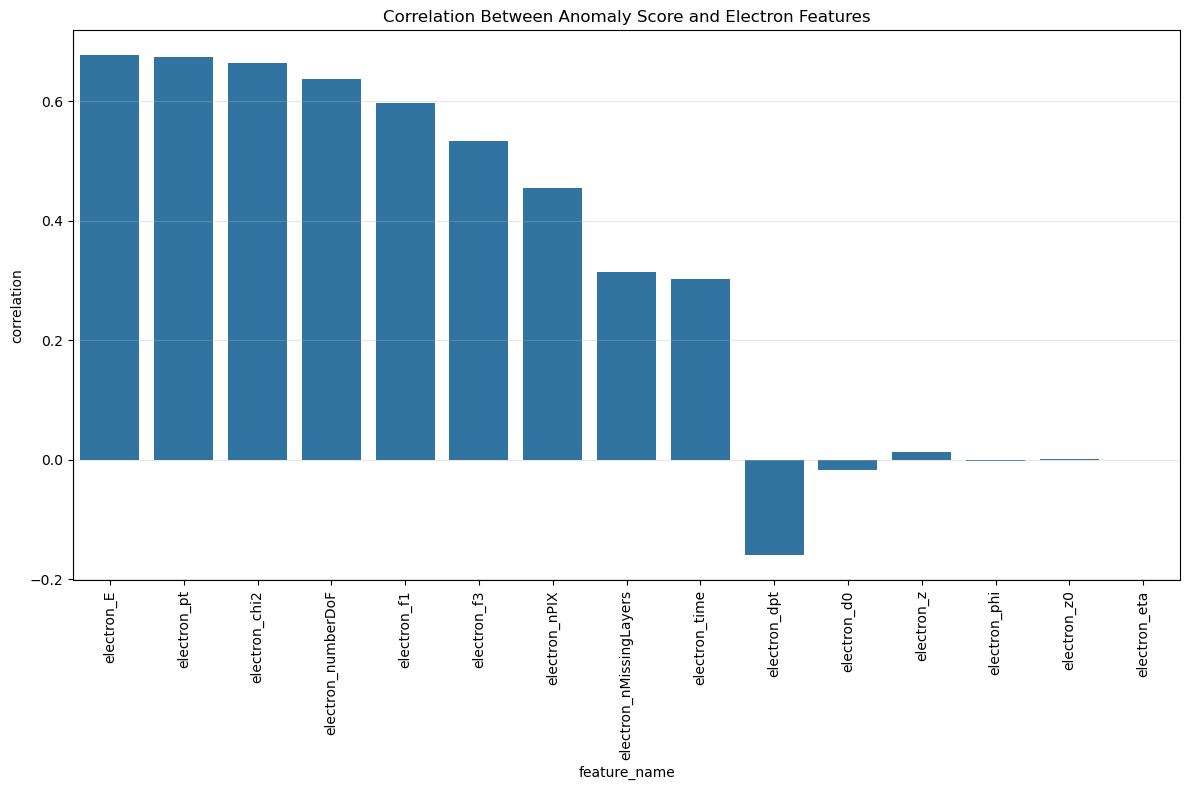

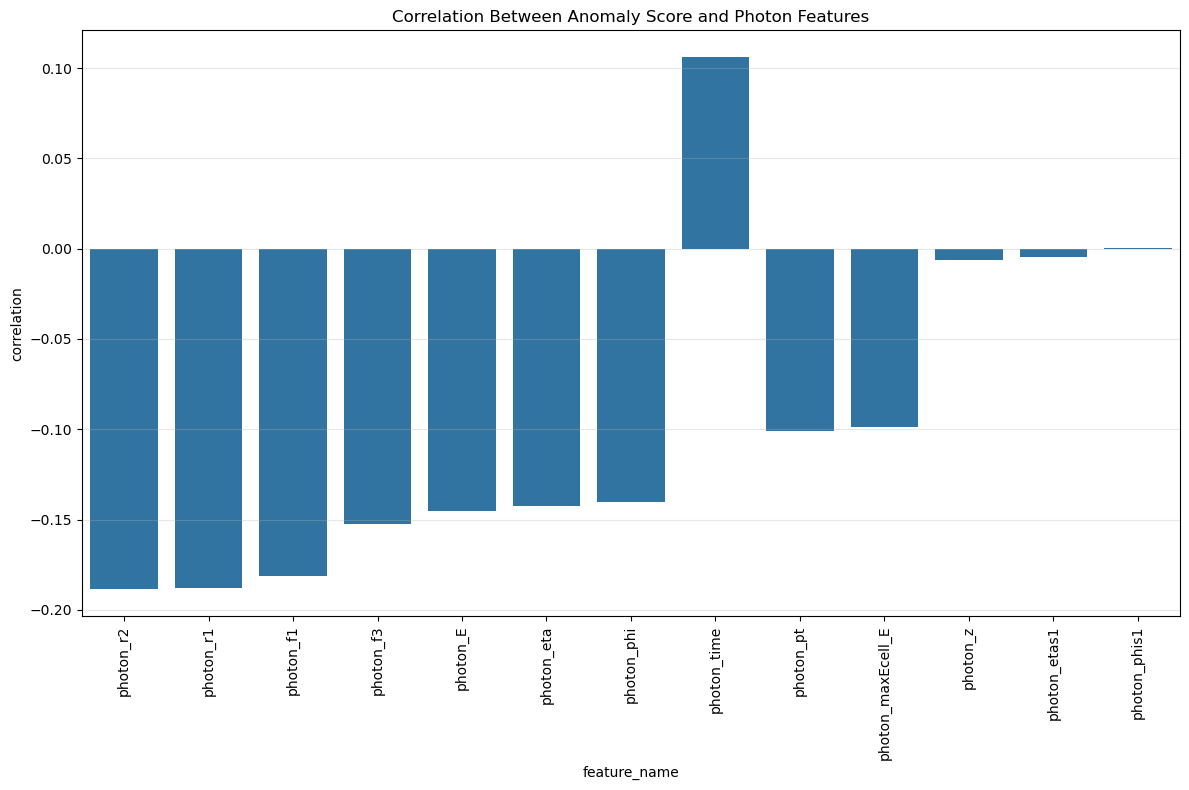


Top electron feature correlations:
  electron_E (idx 0): 0.6773 (p=0.0000e+00)
  electron_pt (idx 1): 0.6744 (p=0.0000e+00)
  electron_chi2 (idx 10): 0.6644 (p=0.0000e+00)
  electron_numberDoF (idx 11): 0.6372 (p=0.0000e+00)
  electron_f1 (idx 12): 0.5975 (p=0.0000e+00)
  electron_f3 (idx 13): 0.5332 (p=0.0000e+00)
  electron_nPIX (idx 8): 0.4557 (p=0.0000e+00)
  electron_nMissingLayers (idx 9): 0.3145 (p=0.0000e+00)
  electron_time (idx 4): 0.3023 (p=0.0000e+00)
  electron_dpt (idx 7): -0.1604 (p=0.0000e+00)

Top photon feature correlations:
  photon_r2 (idx 9): -0.1887 (p=0.0000e+00)
  photon_r1 (idx 8): -0.1879 (p=0.0000e+00)
  photon_f1 (idx 6): -0.1814 (p=0.0000e+00)
  photon_f3 (idx 7): -0.1522 (p=0.0000e+00)
  photon_E (idx 0): -0.1454 (p=0.0000e+00)
  photon_eta (idx 2): -0.1427 (p=0.0000e+00)
  photon_phi (idx 3): -0.1402 (p=0.0000e+00)
  photon_time (idx 4): 0.1061 (p=0.0000e+00)
  photon_pt (idx 1): -0.1012 (p=0.0000e+00)
  photon_maxEcell_E (idx 5): -0.0987 (p=0.0000e+00)


In [18]:
# Main execution
# 1. Calculate correlations
corr_results = calculate_feature_correlations(all_scores, 
                                             np.concatenate([test_electron_features, signal_electron_features]), 
                                             np.concatenate([test_photon_features, signal_photon_features]), 
                                             method='spearman')

# 2. Plot correlation results
e_corrs, p_corrs = plot_correlation_results(corr_results, 
                                           electron_features_list, 
                                           photon_features_list)

In [19]:
def plot_top_feature_score_correlations(scores, e_feats, p_feats, e_corrs, p_corrs, 
                                       signal_labels, n_features=3):
    """
    Create 2D scatter plots of anomaly scores vs top correlated features,
    colored by signal/background.
    
    Parameters:
    -----------
    scores: Anomaly scores
    e_feats: Electron features
    p_feats: Photon features
    e_corrs: Electron correlations DataFrame (from plot_correlation_results)
    p_corrs: Photon correlations DataFrame (from plot_correlation_results)
    signal_labels: Binary labels (1 for signal, 0 for background)
    n_features: Number of top features to plot
    """
    # Get top electron features
    top_e_features = e_corrs.iloc[:n_features]['feature_idx'].astype(int).tolist()
    top_e_names = e_corrs.iloc[:n_features]['feature_name'].tolist()
    
    # Get top photon features
    top_p_features = p_corrs.iloc[:n_features]['feature_idx'].astype(int).tolist()
    top_p_names = p_corrs.iloc[:n_features]['feature_name'].tolist()
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(top_e_features) + len(top_p_features), 1, 
                            figsize=(12, 6 * (len(top_e_features) + len(top_p_features))))
    
    if n_features == 1:  # Make sure axes is always a list
        axes = [axes]
    
    # Plot electron features
    for i, (feat_idx, feat_name) in enumerate(zip(top_e_features, top_e_names)):
        # Get mean feature value for each event
        feat_values = np.mean(e_feats[:, :, feat_idx], axis=1)
        
        # Split by signal/background
        signal_mask = signal_labels == 1
        bkg_mask = signal_labels == 0
        
        # Plot
        ax = axes[i]
        
        # Background points
        scatter_bkg = ax.scatter(feat_values[bkg_mask], scores[bkg_mask], 
                                alpha=0.5, c='blue', label='Background')
        
        # Signal points
        scatter_sig = ax.scatter(feat_values[signal_mask], scores[signal_mask], 
                                alpha=0.5, c='red', label='Signal')
        
        # Add best fit lines
        if len(feat_values[bkg_mask]) > 1:
            z_bkg = np.polyfit(feat_values[bkg_mask], scores[bkg_mask], 1)
            p_bkg = np.poly1d(z_bkg)
            x_range = np.linspace(min(feat_values[bkg_mask]), max(feat_values[bkg_mask]), 100)
            ax.plot(x_range, p_bkg(x_range), "b--", alpha=0.8, label='Bkg trend')
            
        if len(feat_values[signal_mask]) > 1:
            z_sig = np.polyfit(feat_values[signal_mask], scores[signal_mask], 1)
            p_sig = np.poly1d(z_sig)
            x_range = np.linspace(min(feat_values[signal_mask]), max(feat_values[signal_mask]), 100)
            ax.plot(x_range, p_sig(x_range), "r--", alpha=0.8, label='Signal trend')
        
        ax.set_xlabel(feat_name)
        ax.set_ylabel('Anomaly Score')
        ax.set_title(f'Anomaly Score vs {feat_name} (corr={e_corrs.iloc[i]["correlation"]:.4f})')
        ax.legend()
        ax.grid(alpha=0.3)
    
    # Plot photon features
    for i, (feat_idx, feat_name) in enumerate(zip(top_p_features, top_p_names)):
        # Get mean feature value for each event
        feat_values = np.mean(p_feats[:, :, feat_idx], axis=1)
        
        # Split by signal/background
        signal_mask = signal_labels == 1
        bkg_mask = signal_labels == 0
        
        # Plot
        ax = axes[i + len(top_e_features)]
        
        # Background points
        scatter_bkg = ax.scatter(feat_values[bkg_mask], scores[bkg_mask], 
                                alpha=0.5, c='blue', label='Background')
        
        # Signal points
        scatter_sig = ax.scatter(feat_values[signal_mask], scores[signal_mask], 
                                alpha=0.5, c='red', label='Signal')
        
        # Add best fit lines
        if len(feat_values[bkg_mask]) > 1:
            z_bkg = np.polyfit(feat_values[bkg_mask], scores[bkg_mask], 1)
            p_bkg = np.poly1d(z_bkg)
            x_range = np.linspace(min(feat_values[bkg_mask]), max(feat_values[bkg_mask]), 100)
            ax.plot(x_range, p_bkg(x_range), "b--", alpha=0.8, label='Bkg trend')
            
        if len(feat_values[signal_mask]) > 1:
            z_sig = np.polyfit(feat_values[signal_mask], scores[signal_mask], 1)
            p_sig = np.poly1d(z_sig)
            x_range = np.linspace(min(feat_values[signal_mask]), max(feat_values[signal_mask]), 100)
            ax.plot(x_range, p_sig(x_range), "r--", alpha=0.8, label='Signal trend')
        
        ax.set_xlabel(feat_name)
        ax.set_ylabel('Anomaly Score')
        ax.set_title(f'Anomaly Score vs {feat_name} (corr={p_corrs.iloc[i]["correlation"]:.4f})')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('feature_score_correlations.png', dpi=300)
    plt.show()

# Replace the previous plot_top_feature_distributions function call with:
plot_top_feature_score_correlations(all_scores,
                                   np.concatenate([test_electron_features, signal_electron_features]),
                                   np.concatenate([test_photon_features, signal_photon_features]),
                                   e_corrs, p_corrs, all_labels, n_features=10)

/lscratch/hjia625/tmp/ipykernel_259367/3122170153.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/lscratch/hjia625/tmp/ipykernel_259367/3122170153.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('feature_score_correlations.png', dpi=300)
